<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ufidon/ml/blob/main/mod6/anns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ufidon/ml/blob/main/mod6/anns.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>
<br>

Introduction to Artificial Neural Networks with Keras
---
_homl3 ch10_


Artificial Neural Networks (ANNs)
---
- versatile, powerful, and scalable ML models for classification and regression
- inspired by the networks of biological neurons but very different
- wide applications
  - classifying billions of images such as Google Images
  - speech recognition such as Google's `OK Google`
  - video recommendation such Youtube
  - defeating world champions in the game of Go such as Deepmind's AlphaZero
- popular ANN frameworks
  - Google TensorFlow
  - Facebook PyTorch
- [Keras](https://keras.io/) is a high-level API for building, training and evaluating ANNs
  - supports multi-backend such as TensorFlow, JAX and PyTorch
- cost for ANNs
  - huge amount of data for training
  - high computing power
  - millions even billions of parameters
- ANNs can theoretically approximate any continuous functions with arbitrary precision
- theoretical limitations such as getting stuck in local optima
  - but practically the local optima often perform almost as well as the global optimum

In [ ]:
import sys
if "google.colab" in sys.modules:
  %pip install -q -U keras-tuner

In [67]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib as mpl
import sklearn as skl, sklearn.datasets as skds

import tensorflow as tf, keras_tuner as kt 

Artificial neuron - TLU
---
- `threshold logic unit (TLU)`, or `linear threshold unit (LTU)`
- computes a `linear function` of its inputs
  - $z=w_1x_1+w_2x_2+⋯+w_mx_m+b=\mathbf{w^Tx}+b$
- then applies a `step function` to z:
  - $h_{\mathbf{w}}(\mathbf{x})=\operatorname{step}(z)$
  - the input weights __w__ and the bias term b are the model's parameters
  - similar to `logistic regression` except it uses a step function instead of the logistic function
- two typical step functions are used
  - Heaviside step function: ${\displaystyle H(z)={\begin{cases}1,&z\geq 0\\0,&z<0\end{cases}}}$
  - sign function: ${\displaystyle \operatorname {sgn} (z)={\begin{cases}-1&{\text{if }}z<0,\\0&{\text{if }}z=0,\\1&{\text{if }}z>0.\end{cases}}}$
- A single TLU can be used for simple linear binary classification
  - computes a linear function of its inputs
  - outputs the positive class if the result exceeds a threshold
    - otherwise the negative class

Perceptron
---
- composed of one or more TLUs organized in a single layer
  - every TLU is connected to every input
  - such a layer is called a `fully connected layer`, or a `dense layer`
- The inputs constitute the `input layer`
  - since the layer of TLUs produces the final outputs, it is called the `output layer`
- ∴ The perceptron can classify instances simultaneously into multiple
different binary classes
  - which makes it a `multilabel classifier` 
  - can also be used for `multiclass classification`
- The decision boundary of each output neuron is `linear`
  - incapable of learning complex patterns
- implemented in sklearn `Perceptron class`

Computing the outputs of a fully connected layer
---
- ${\displaystyle h_{\mathbf{w,b}}} (\mathbf{X}) = ϕ(\mathbf{XW+b})$
- $\mathbf{X}$, the matrix of inputs, one row per instance and one column per feature
- $\mathbf{W}$, the matrix of weights, one row per input and one column per neuron
- $\mathbf{b}$, the bias vector, one bias per neuron
- $ϕ$, the `activation` function,  a step function for TLUs

Training perceptron
---
- update weights by ${\displaystyle w_{i,j}^{(k+1)} = w_{i,j}^{(k)} +  η(y_j - \hat{y_j})x_i }$
  - $w_{i,j}$, the connection weight between the $i^{th}$ input and the $j^{th}$ neuron
  - $x_i$, the $i^{th}$ input value of the current training instance
  - $\hat{y_j}$, the output of the $j^{th}$ output neuron for the current training instance
  - $y_j$, the target output of the $j^{th}$ output neuron for the current training instance
  - η, the learning rate
- the biases $b_j$ are included as $b_j = w_{0,j}x_0$, where $x_0=1$

In [68]:
# 1. classify iris with perceptron
# train the perceptron as a binary classifier: setosa or not-setosa

from sklearn.linear_model import Perceptron

iris = skds.load_iris(as_frame=True)
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = (iris.target == 0)  # Iris setosa

per_clf = Perceptron(random_state=42)
per_clf.fit(X, y)

X_new = [[2, 0.5], [3, 1]]
y_pred = per_clf.predict(X_new)  # which flower is setosa
y_pred

array([ True, False])

In [69]:
# 2. The `Perceptron` is equivalent to  a `SGDClassifier` with 
# `loss="perceptron"`, no regularization, and a constant learning rate equal to 1:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="perceptron", penalty=None,
                        learning_rate="constant", eta0=1, random_state=42)
sgd_clf.fit(X, y)
print(f"{(sgd_clf.coef_ == per_clf.coef_).all()}")
print(f"{ (sgd_clf.intercept_ == per_clf.intercept_).all()}")

True
True


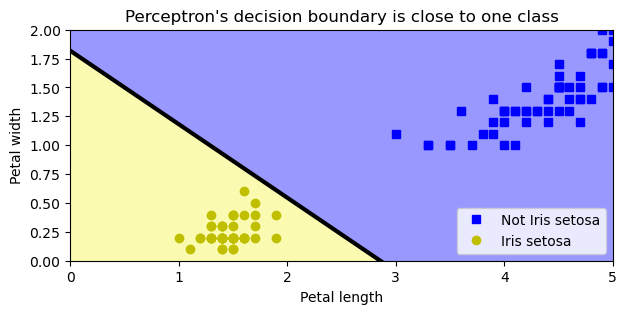

In [70]:
# 3. the Perceptron stops learning once found a decision boundary that properly separates the classes, 
# This means that the decision boundary is often quite close to one class:

from matplotlib.colors import ListedColormap

a = -per_clf.coef_[0, 0] / per_clf.coef_[0, 1]
b = -per_clf.intercept_ / per_clf.coef_[0, 1]
axes = [0, 5, 0, 2]
x0, x1 = np.meshgrid(
    np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
    np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

fig1, ax1 = plt.subplots(figsize=(7, 3))
ax1.plot(X[y == 0, 0], X[y == 0, 1], "bs", label="Not Iris setosa")
ax1.plot(X[y == 1, 0], X[y == 1, 1], "yo", label="Iris setosa")
ax1.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-",
         linewidth=3)
ax1.contourf(x0, x1, zz, cmap=custom_cmap)
ax1.set_xlabel("Petal length")
ax1.set_ylabel("Petal width")
ax1.legend(loc="lower right")
ax1.set_title("Perceptron's decision boundary is close to one class")
ax1.axis(axes);

Multilayer perceptron (MLP)
---
- Perceptrons can't classify non-linearly separable dataset such as `the XOR problem`
  - x1 xor x2: (0,0) and (1,1) output 0, (0,1) and (1,0) output 1
  - these two classes cross over each other so they are non-linearly separable
- This limitation can be solved with ` multilayer perceptron (MLP)` 
  - which stacks multiple perceptrons
  - ![mlp](./img/mlp.png)
  - 1 `input layer` → 1⁺ intermediate or `hidden layers` → 1 `output layer`
    - An ANN that has a deep stack of hidden layers is called a `deep neural network (DNN)`
  - layers close to the input layer are called `lower layers`
  - layers close to the output layer are called `upper layers`
- The MLP below solves the XOR problem
- ![mlpxor](./img/mlpxor.png)
  - `(0,0): p1(0*1+0*1-3/2)=0, p2(0*1+0*1>-1/2)=0, p3(-1*0+1*0-1/2)=0`
  - `(0,1): p1(0*1+1*1-3/2)=0, p2(0*1+1*1-1/2)=1, p3(-1*0+1*1-1/2)=1`
  - `(1,0): p1(1*1+0*1-3/2)=0, p2(1*1+0*1-1/2)=1, p3(-1*0+1*1-1/2)=1`
  - `(1,1): p1(1*1+1*1-3/2)=1, p2(1*1+1*1-1/2)=1, p3(-1*1+1*1-1/2)=0`


Backpropagation
---
- Backpropagation (`backprop`) is an efficient way to train an ANN. It's a combination of two steps
  - `reverse-mode autodiff`: 
    - computes the `gradients` of the neural network’s error with regard to every single model parameter in two passes through the network 
    - one forward, one backward
  - `gradient descent`: exploits the gradients calculated from reverse-mode autodiff
- repeat these two steps, the neural network’s error will gradually drop until it eventually reaches a minimum
- Backpropagation can be applied to all sorts of computational graphs, not just NNs
- There are various autodiff techniques, with different pros and cons
  

Train an ANN with backprop
---
- initialize all weights and biases randomly
- handle one mini-batch out of the training set at a time
  - each pass of the whole training set is called an `epoch`
- forward pass: 
  - each mini-batch go through the ANN from the input layer to the output layer
  - exactly like prediction except keeping all intermediate results for the backward pass
- backward pass:
  - measure the `error gradients` across all the connection weights and biases came from each layer
  - from the output layer backward to the input layer
- tweak all the connection weights and biases through a `gradient descent step` using the error gradients
- to make the `gradient descent step` working, the `step function` in the MLP is replaced with `derivable functions` with `nonzero derivative` such as `sigmoid function`
  - these functions are called `activation function`
  - they introduce `nonlinearity` into the ANN

Popular activation functions
---
- sigmoid function: ${\displaystyle \sigma (z)={\frac {1}{1+e^{-z}}}={\frac {e^{z}}{1+e^{z}}}=1-\sigma (-z)}$
  - range: (0,1)
- hyperbolic tangent function: ${\displaystyle f(z)=\tanh z={\frac {e^{z}-e^{-z}}{e^{z}+e^{-z}}} = 2σ(2z) – 1}$
  - range: (-1,1)
- rectified linear unit function: ${\displaystyle \operatorname{ReLU}(z) = \max(0, z)}$
  - range: [0, ∞)
- softplus, a smooth variant of ReLU: ${\displaystyle \operatorname{softplus}(z) = \log(1+e^z)}$
  - range: (0, ∞)

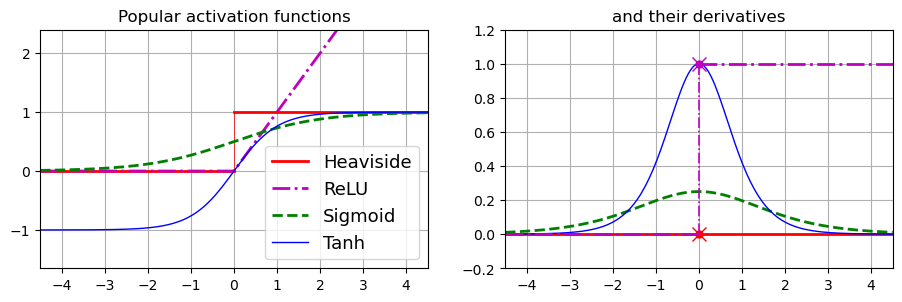

In [71]:
# 1. Popular activation functions
from scipy.special import expit as sigmoid

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

max_z = 4.5
z = np.linspace(-max_z, max_z, 200)

fig2, ax2 = plt.subplots(1,2, figsize=(11, 3.1))


ax2[0].plot([-max_z, 0], [0, 0], "r-", linewidth=2, label="Heaviside")
ax2[0].plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
ax2[0].plot([0, 0], [0, 1], "r-", linewidth=0.5)
ax2[0].plot([0, max_z], [1, 1], "r-", linewidth=2)
ax2[0].plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
ax2[0].plot(z, np.tanh(z), "b-", linewidth=1, label="Tanh")
ax2[0].grid(True)
ax2[0].set_title("Popular activation functions")
ax2[0].axis([-max_z, max_z, -1.65, 2.4])
ax2[0].set_yticks([-1, 0, 1, 2])
ax2[0].legend(loc="lower right", fontsize=13)


ax2[1].plot(z, derivative(np.sign, z), "r-", linewidth=2, label="Heaviside")
ax2[1].plot(0, 0, "ro", markersize=5)
ax2[1].plot(0, 0, "rx", markersize=10)
ax2[1].plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
ax2[1].plot(z, derivative(np.tanh, z), "b-", linewidth=1, label="Tanh")
ax2[1].plot([-max_z, 0], [0, 0], "m-.", linewidth=2)
ax2[1].plot([0, max_z], [1, 1], "m-.", linewidth=2)
ax2[1].plot([0, 0], [0, 1], "m-.", linewidth=1.2)
ax2[1].plot(0, 1, "mo", markersize=5)
ax2[1].plot(0, 1, "mx", markersize=10)
ax2[1].grid(True)
ax2[1].set_title("and their derivatives")
ax2[1].axis([-max_z, max_z, -0.2, 1.2]);

Regression MLPs
---
- For `univariate regression`, 
  - a single output neuron is used to predict a single value 
- For `multivariate regression`, 
  - multiple output neurons are used to predict multiple values at once
- implemented in sklearn `MLPRegressor class`
- ⚠️ the MLPRegressor class does not support activation functions in the output layer
  - so it’s free to output any value it wants
- Typical regression MLP architecture

| Hyperparameter |  Typical value |
|:--:|:--:|
| # hidden layers |  Depends on the problem, but typically 1 to 5 |
| # neurons per hidden |  Depends on the problem, but typically 10 to 100  |
| # output neurons |  1 per prediction dimension |
| Hidden activation |  ReLU |
| Output activation |  None, or ReLU/softplus (if positive outputs) or sigmoid/tanh (if bounded outputs) |
| Loss function |  MSE, or [Huber](https://en.wikipedia.org/wiki/Huber_loss) if too many outliers |

In [72]:
# 1. predict California housing prices 
# using MLPRegressor with three hidden layers composed of 50 neurons each
# 
# a) create a pipeline to standardize the input features 
#    before sending them to the MLPRegressor because 
#    gradient descent does not converge very well 
#    when the features have very different scales
# b) by default, the model uses
#    the ReLU activation function in the hidden layers
#    a variant of gradient descent called `Adam` to minimize the mean square error
#       with a little bit of `l2 regularization` 
#       which can be tuned with the `alpha` hyperparameter

from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

mlp_reg = MLPRegressor(hidden_layer_sizes=[50, 50, 50], random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_reg)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpregressor',
                 MLPRegressor(hidden_layer_sizes=[50, 50, 50],
                              random_state=42))])

In [73]:
y_pred = pipeline.predict(X_valid)
rmse = mean_squared_error(y_valid, y_pred, squared=False)
rmse

/opt/micromamba/envs/ml/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.5053326657968407

Classification MLPs
---
- using the `sigmoid` activation function
  - for `binary` classification (BC),  
    - a single output neuron outputs a probability
  - for `multilabel binary` classification (MLC),
    - multiple output neurons output multiple probabilities
      -  the output probabilities do `not` necessarily add up to 1
    - e.x. given an email, 
      - one neuron predicts for urgent or non-urgent
      - another neuron predicts for spam or non-spam
- using the `softmax` activation function for `multiclass` classification (MCC)
  - `softmax` ensures that 
    - all the estimated probabilities are between 0 and 1 
    - and that they add up to 1, since the classes are exclusive
  - one output neuron per class is needed
- the generally used `loss` function is
    - cross-entropy loss (or x-entropy or log loss for short)
    - since we are predicting probability distributions
- implemented in sklearn `MLPClassifier class`
- Typical classification MLP architecture

| Hyperparameter | Binary classification | Multilabel binary classification | Multiclass classification|
|:--:|:--:|:--:|:--:|
| # hidden layers |  Typically 1 to 5 layers, depending on the task | as BC. | as BC. |
| # output neurons |  1 |  1 per binary label |  1 per class |
| Output layer activation |  Sigmoid | Sigmoid | Softmax |
| Loss function |  X-entropy | X-entropy | X-entropy |

In [74]:
# 1. Classify iris flowers

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

iris = load_iris()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    iris.data, iris.target, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, test_size=0.1, random_state=42)

# 1 hidden layer with 5 neurons
mlp_clf = MLPClassifier(hidden_layer_sizes=[5], max_iter=10_000,
                        random_state=42)
pipeline = make_pipeline(StandardScaler(), mlp_clf)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(hidden_layer_sizes=[5], max_iter=10000,
                               random_state=42))])

In [75]:
accuracy = pipeline.score(X_valid, y_valid)
accuracy

1.0

Building an Image Classifier Using Keras Sequential API
---
- Fashion MNIST contains 70,000 grayscale images of 28 × 28 pixels each
  - the images represent fashion items
    - is more diverse than Digit MNIST
  - already shuffled and split into a training set (60,000 images) and a test set (10,000 images)

In [76]:
# 1. fetch Fashion MNIST with Keras
# We'll use 55,000 images for training, 
#   and 5,000 for validation both from the training set

import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [77]:
# 2. Each image is grays, 28x28 pixels
#    Each pixel intensity is represented as a byte (0 to 255)
#    there are 10 classes
X_train.shape, X_train.dtype, np.unique(y_train)

((55000, 28, 28),
 dtype('uint8'),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8))

In [78]:
# 3. scale the pixel intensities down to the 0-1 range and convert them to floats
X_train, X_valid, X_test = X_train / 255., X_valid / 255., X_test / 255.

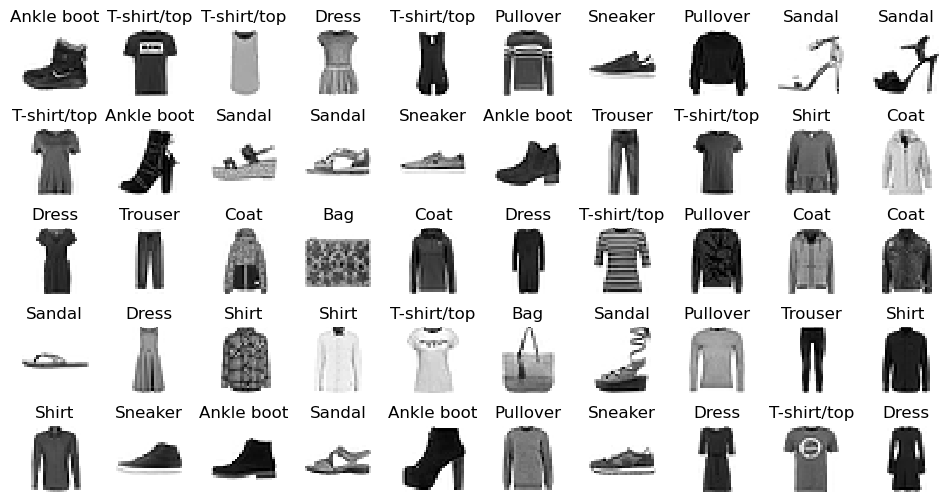

In [79]:
# 4. show the first 50 fashions
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

n_rows = 5
n_cols = 10
fig3 = plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

In [80]:
# 5. Build the model using Keras sequential API
# 5.1 method 1: build layer by layer

# 2) compose a single stack of layers connected sequentially
model = tf.keras.Sequential()

# 3) 2D (28,28) to 1D (28*28)
model.add(tf.keras.layers.InputLayer(input_shape=[28, 28]))
model.add(tf.keras.layers.Flatten())

# 4) Each Dense layer manages its own weight matrix
#     containing all the connection weights and a vector of bias terms
#   # of parameters for n neurons:  
#       (# of inputs)*n weights + n biases = (#number of inputs + 1)*n
#       e.x. for layer `dense`: (784+1)*300 = 235,500

model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))

# 5) a Dense output layer with 10 neurons (one per class)
model.add(tf.keras.layers.Dense(10, activation="softmax"))


In [81]:
# 5.2 method 2: pass a list of layers to the Sequential constructor

# 1) clear the session to reset the name counters
tf.keras.backend.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [82]:
# 6. summarize the model
#   1) `None` in the output shape means the batch size can be anything
#   2) the layer name can be set explicitly or leave implicitly 
#       and must be `unique` across models, 
#       this makes it possible to merge models without name conflicts

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


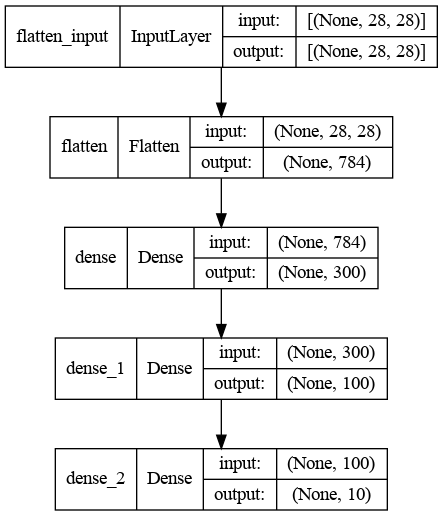

In [83]:
# 7. visualize the model's architecture
tf.keras.utils.plot_model(model, show_shapes=True)

In [84]:
# 8. access model layers
# 1) access all layers
model.layers

In [85]:
# 2) access a specified layer by index or by name
hidden1 = model.layers[1]
hidden1.name, model.get_layer('dense') is hidden1

('dense', True)

In [86]:
# 3) access a layer's weights and biases
weights, biases = hidden1.get_weights()
weights.shape, biases.shape

((784, 300), (300,))

In [87]:
# 4)  the connection weights were initialized randomly
#        which is needed to break symmetry
#     the biases were initialized to zeros, which is fine
# different initialization method can be specified with 
#   - `kernel_initializer` 
#       - kernel is another name for the matrix of connection weights
#   - bias_initializer``
weights, biases

(array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
          0.03859074, -0.06889391],
        [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
         -0.02763776, -0.04165364],
        [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
          0.07121518, -0.07331658],
        ...,
        [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
          0.00228987,  0.05581069],
        [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
          0.00034875,  0.02878492],
        [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
          0.00272203, -0.06793761]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [88]:
# 9. compile the model
#  1) specify the `loss` function, the `optimizer` and `metrics`
# a) `sparse_categorical_crossentropy` for sparse labels which have 
#     only one exclusive target class index out of 10 for each instance
#     `categorical_crossentropy` is needed for 
#     one target probability per class for each instance
# b) for binary classification or multilabel binary classification
#     we need "sigmoid" activation function in the output layer
#     and the "binary_crossentropy" loss

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

In [89]:
# 2) equivalent to 1)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])

In [90]:
# 10. train and evaluate the model
# ∵ default batch size = 32 instances
# ∴ 55000 images result in ⌈55000/32 ⌉ = 1719 batches per epoch
# each epoch outputs: 
#   - the mean training time, 
#   - the loss and accuracy for both training and validation

# 1) the validation data is provided explicitly here
#   it can also be provided by setting `validation_split=0.1`
#   to use the last 10% of the data
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
 435/1719 [======>.......................] - ETA: 2s - loss: 1.1144 - sparse_categorical_accuracy: 0.6573

1719/1719 [==============================] - 3s 2ms/step - loss: 0.7220 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.4961 - val_sparse_categorical_accuracy: 0.8328
Epoch 2/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4825 - sparse_categorical_accuracy: 0.8333 - val_loss: 0.4558 - val_sparse_categorical_accuracy: 0.8390
Epoch 3/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4368 - sparse_categorical_accuracy: 0.8479 - val_loss: 0.4237 - val_sparse_categorical_accuracy: 0.8548
Epoch 4/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4121 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.3967 - val_sparse_categorical_accuracy: 0.8624
Epoch 5/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3910 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.3892 - val_sparse_categorical_accuracy: 0.8612
Epoch 6/30
1719/1719 [==============================] - 3s 2ms/step - loss: 0.3750 - sparse_categoric

- there is a little bit of overfitting since 
  - the validation accuracy = 0.8880 < the training accuracy=0.9201
- for unbalanced dataset, the `fit()` argument `class_weight` can be used to
  - give a larger weight to underrepresented classes 
  - and a lower weight to overrepresented classes
- if samples have different quality, the `fit()` argument `sample_weight` can be used to
  - give a larger weight to samples with better quality
  - and a lower weight to samples with worse quality
- If both `class_weight` and `sample_weight` are provided, then Keras multiplies them
- sample weights (but not class weights) can also be applied on the validation set by
  - by adding them as a third item in the validation_data tuple

- The fit() method returns a `History object` containing
  - the training parameters `history.params`
  - the list of epochs it went through `history.epoch`
  - and a dictionary `history.history` containing 
    - the loss and extra metrics it measured at the end of each epoch 
      - on the training set and on the validation set (if any)

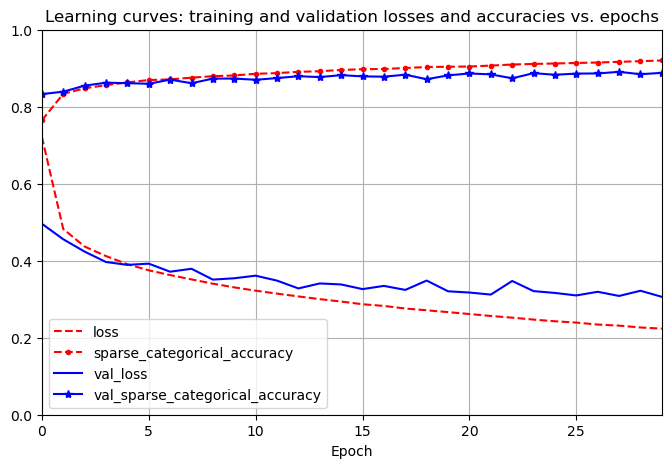

In [91]:
# 1. compare training and validations errors and accuracies

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 29], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left");
plt.title("Learning curves: training and validation losses and accuracies vs. epochs");

- The validation error is computed at the end of each epoch, 
   - while the training error is computed using a running mean during each epoch
 - so the model looks like it performed better on the validation set than on the training set at the beginning of training, which is NOT true

In [92]:
# 2. evaluate the model on the test set

model.evaluate(X_test, y_test)

  1/313 [..............................] - ETA: 3s - loss: 0.4091 - sparse_categorical_accuracy: 0.9062

313/313 [==============================] - 0s 1ms/step - loss: 0.3254 - sparse_categorical_accuracy: 0.8839


[0.3253977596759796, 0.883899986743927]

In [93]:
# 3. make predictions
#   For each instance the model estimates one probability per class, 
#   from class 0 to class 9
numtest = 5
X_new, y_new = X_test[:numtest], y_test[:numtest]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.23, 0.  , 0.01, 0.  , 0.  , 0.  , 0.76, 0.  , 0.  , 0.  ]],
      dtype=float32)

In [94]:
# 2) find the predicted class index and name
y_pred = y_proba.argmax(axis=-1)
y_pred, np.array(class_names)[y_pred]

(array([9, 2, 1, 1, 6]),
 array(['Ankle boot', 'Pullover', 'Trouser', 'Trouser', 'Shirt'],
       dtype='<U11'))

In [95]:
# 3) check the prediction
y_pred == y_new

array([ True,  True,  True,  True,  True])

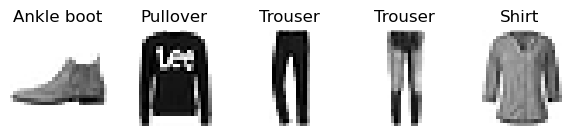

In [96]:
# 4) check with naked eyes
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, numtest, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

Building a Regression MLP Using Keras Sequential API
---
- the process is quite similar to classification MLP
- main differences
  - the output layer 
    - uses a single neuron for predicting a single value
    - no activation function
  - the loss function is mean squared error
    - the metric is RMSE
    - the optimizer is Adam like the one used in sklearn MLPRegressor
  - the first layer is a Normalization layer instead of a Flatten layer
    - used to scale the data as sklearn StandardScaler

In [97]:
# 1. build a Regression MLP Using Keras Sequential API 
#   for predicting the California housing prices

# 1) load, split and scale the California housing dataset
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

In [98]:
X_train.shape

(11610, 8)

In [99]:
# 2) build and train a regression MLP
# The Normalization layer learns the feature means and standard deviations 
#   in the training data when you call the adapt() method
#   these parameters are not affected by gradient descent 
#     so they are listed as non-trainable

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
 48/363 [==>...........................] - ETA: 0s - loss: 2.8166 - root_mean_squared_error: 1.6783  

363/363 [==============================] - 1s 1ms/step - loss: 0.9051 - root_mean_squared_error: 0.9514 - val_loss: 0.4030 - val_root_mean_squared_error: 0.6348
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3843 - root_mean_squared_error: 0.6199 - val_loss: 0.8436 - val_root_mean_squared_error: 0.9185
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3609 - root_mean_squared_error: 0.6007 - val_loss: 0.3744 - val_root_mean_squared_error: 0.6119
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3416 - root_mean_squared_error: 0.5844 - val_loss: 0.4343 - val_root_mean_squared_error: 0.6590
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3301 - root_mean_squared_error: 0.5746 - val_loss: 0.3085 - val_root_mean_squared_error: 0.5554
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3168 - root_mean_squared_error: 0.5629 - val_loss: 0.4544 - val_root_mean_s

In [100]:
# 3) evaluate the model
mse_test, rmse_test = model.evaluate(X_test, y_test)

 78/162 [=============>................] - ETA: 0s - loss: 0.2779 - root_mean_squared_error: 0.5272

162/162 [==============================] - 0s 617us/step - loss: 0.2812 - root_mean_squared_error: 0.5303


In [101]:
# 4) make predictions
numtest = 5
X_new, y_new = X_test[:numtest], y_test[:numtest]
y_pred = model.predict(X_new)
print(f"{y_new=}\n{y_pred=}")

y_new=array([0.477  , 0.458  , 5.00001, 2.186  , 2.78   ])
y_pred=array([[0.48159295],
       [1.1848724 ],
       [4.969157  ],
       [2.525544  ],
       [2.971431  ]], dtype=float32)


Building Complex Models Using Keras Functional API
---
- One example of a nonsequential neural network is a `Wide & Deep` neural network (wdnn)
  - It connects all or part of the inputs directly to the output layer
  - It is able to learn 
    - both deep patterns (through the deep path) 
    - and simple rules (through the short path)
- ![wdnn](./img/wdnn.png)

In [102]:
# 1. build a wdnn to predict the California housing prices
# 1) reset the name counters and make the code reproducible
tf.keras.backend.clear_session()

In [103]:
# 2) build the wdnn

# build layers
normalization_layer = tf.keras.layers.Normalization()
hidden_layer1 = tf.keras.layers.Dense(30, activation="relu")
hidden_layer2 = tf.keras.layers.Dense(30, activation="relu")
concat_layer = tf.keras.layers.Concatenate()
output_layer = tf.keras.layers.Dense(1)

# connect layers
input_ = tf.keras.layers.Input(shape=X_train.shape[1:])
normalized = normalization_layer(input_)
hidden1 = hidden_layer1(normalized)
hidden2 = hidden_layer2(hidden1)
concat = concat_layer([normalized, hidden2])
output = output_layer(concat)

model = tf.keras.Model(inputs=[input_], outputs=[output])

In [104]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 30)           270         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 30)           930         ['dense[0][0]']                  
                                                                                              

In [105]:
# 3. train the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
normalization_layer.adapt(X_train)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
  1/363 [..............................] - ETA: 1:09 - loss: 4.1043 - root_mean_squared_error: 2.0259

363/363 [==============================] - 1s 1ms/step - loss: 0.8358 - root_mean_squared_error: 0.9142 - val_loss: 0.5117 - val_root_mean_squared_error: 0.7153
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4329 - root_mean_squared_error: 0.6579 - val_loss: 0.7802 - val_root_mean_squared_error: 0.8833
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3900 - root_mean_squared_error: 0.6245 - val_loss: 0.3525 - val_root_mean_squared_error: 0.5937
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3646 - root_mean_squared_error: 0.6038 - val_loss: 0.3524 - val_root_mean_squared_error: 0.5937
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3523 - root_mean_squared_error: 0.5935 - val_loss: 0.3285 - val_root_mean_squared_error: 0.5731
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3419 - root_mean_squared_error: 0.5847 - val_loss: 0.6086 - val_root_mean_s

In [106]:
# 4. evaluate the model and make prediction
mse_test = model.evaluate(X_test, y_test)
y_pred = model.predict(X_new)

 75/162 [============>.................] - ETA: 0s - loss: 0.3038 - root_mean_squared_error: 0.5512

162/162 [==============================] - 0s 638us/step - loss: 0.2993 - root_mean_squared_error: 0.5471


In [107]:
print(f"{y_pred.flatten()=}\n{y_new=}")

y_pred.flatten()=array([0.44989687, 1.2359425 , 4.592379  , 2.550535  , 2.70434   ],
      dtype=float32)
y_new=array([0.477  , 0.458  , 5.00001, 2.186  , 2.78   ])


Multiple-input WDNN
---
- separates the features input two subsets
  - one subset goes through the wide path
  - the other one goes through the deep path
- ![miwd](./img/miwd.png)

In [108]:
# 1. build a multiple-input WDNN for the California housing problem again
#   the California housing dataset has 8 features
#   - 5 features through the wide path (features 0 to 4)
#   - 6 features through the deep path (features 2 to 7)


input_wide = tf.keras.layers.Input(shape=[5])  # 5 features
input_deep = tf.keras.layers.Input(shape=[6])  # 6 features 
norm_layer_wide = tf.keras.layers.Normalization()
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu")(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)

model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])

In [109]:
# 2. compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 normalization_2 (Normalization  (None, 6)           13          ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 30)           210         ['normalization_2[0][0]']  

In [110]:
# 3. train the model
#  X_train[:, :5] - 5 features through the wide path (features 0 to 4)
#  X_train[:, 2:] - 6 features through the deep path (features 2 to 7)
X_train_wide, X_train_deep = X_train[:, :5], X_train[:, 2:]
X_valid_wide, X_valid_deep = X_valid[:, :5], X_valid[:, 2:]
X_test_wide, X_test_deep = X_test[:, :5], X_test[:, 2:]

norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit((X_train_wide, X_train_deep), y_train, epochs=20,
                    validation_data=((X_valid_wide, X_valid_deep), y_valid))

Epoch 1/20
363/363 [==============================] - 1s 1ms/step - loss: 1.2768 - root_mean_squared_error: 1.1300 - val_loss: 0.9497 - val_root_mean_squared_error: 0.9745
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4767 - root_mean_squared_error: 0.6904 - val_loss: 1.4311 - val_root_mean_squared_error: 1.1963
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4433 - root_mean_squared_error: 0.6658 - val_loss: 0.4258 - val_root_mean_squared_error: 0.6525
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4057 - root_mean_squared_error: 0.6370 - val_loss: 0.4009 - val_root_mean_squared_error: 0.6332
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3939 - root_mean_squared_error: 0.6276 - val_loss: 1.4774 - val_root_mean_squared_error: 1.2155
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3873 - root_mean_squared_error: 0.6223 - val_loss: 2.6819 - val_

In [111]:
# 4. evaluate the model and make predictions
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)

X_new_wide, X_new_deep = X_test_wide[:numtest], X_test_deep[:numtest]
y_pred = model.predict((X_new_wide, X_new_deep))

 50/162 [========>.....................] - ETA: 0s - loss: 0.3449 - root_mean_squared_error: 0.5873

162/162 [==============================] - 0s 876us/step - loss: 0.3383 - root_mean_squared_error: 0.5817


In [112]:
print(f"{y_pred.flatten()=}\n{y_new=}")

y_pred.flatten()=array([0.24496524, 1.1924739 , 3.5039153 , 2.3702316 , 2.7661033 ],
      dtype=float32)
y_new=array([0.477  , 0.458  , 5.00001, 2.186  , 2.78   ])


Multiple-input & multiple output WDNN
---
- many use cases need multiple outputs
  - to locate and classify objects in a picture is 
    - a task that combines regression and classification
  - multitask classification of images of animals
    - one output for the animal type and the other one for its gesture
  - outputs from different paths through the nn
    - e.x. add an auxiliary output for regularization
- ![mimo](./img/mimo.png)

In [113]:
# 1. Adding an auxiliary output for regularization
#   as the figure above
tf.keras.backend.clear_session()

input_wide = tf.keras.layers.Input(shape=[5], name='input_wide')  
input_deep = tf.keras.layers.Input(shape=[6], name='input_deep')  
norm_layer_wide = tf.keras.layers.Normalization(name='norm_wide')
norm_layer_deep = tf.keras.layers.Normalization(name='norm_deep')
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)
hidden1 = tf.keras.layers.Dense(30, activation="relu", name="hidden1")(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation="relu", name='hidden2')(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1, name="main_output")(concat)

aux_output = tf.keras.layers.Dense(1, name='aux_output')(hidden2)

model = tf.keras.Model(inputs=[input_wide, input_deep],
                       outputs=[output, aux_output])

In [114]:
# 2. compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

#  1) If we pass a single loss, Keras will assume that the same loss 
#     must be used for all outputs
#  2) By default, Keras will compute all the losses and simply add 
#     them up to get the final loss used for training
#  3) it is possible to set all the loss weights when compiling the model
#     here we care much more about the main output than about the auxiliary output

model.compile(loss=("mse", "mse"), loss_weights=(0.9, 0.1), optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

In [115]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_deep (InputLayer)        [(None, 6)]          0           []                               
                                                                                                  
 norm_deep (Normalization)      (None, 6)            13          ['input_deep[0][0]']             
                                                                                                  
 input_wide (InputLayer)        [(None, 5)]          0           []                               
                                                                                                  
 hidden1 (Dense)                (None, 30)           210         ['norm_deep[0][0]']              
                                                                                              

In [116]:
# 3. train the model
norm_layer_wide.adapt(X_train_wide)
norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=20,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid))
)

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 1.3490 - main_output_loss: 1.2742 - aux_output_loss: 2.0215 - main_output_root_mean_squared_error: 1.1288 - aux_output_root_mean_squared_error: 1.4218 - val_loss: 1.5415 - val_main_output_loss: 0.9593 - val_aux_output_loss: 6.7806 - val_main_output_root_mean_squared_error: 0.9795 - val_aux_output_root_mean_squared_error: 2.6040
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5101 - main_output_loss: 0.4785 - aux_output_loss: 0.7952 - main_output_root_mean_squared_error: 0.6917 - aux_output_root_mean_squared_error: 0.8917 - val_loss: 1.3624 - val_main_output_loss: 1.0094 - val_aux_output_loss: 4.5401 - val_main_output_root_mean_squared_error: 1.0047 - val_aux_output_root_mean_squared_error: 2.1307
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4618 - main_output_loss: 0.4404 - aux_output_loss: 0.6546 - main_output_root_mean_squared_error: 0.6636 - aux_output

In [117]:
# 4. evaluate the model 
#   1) labels must be provided for each output
#       here they predict the same thing so they use the same labels
#   2)  the weighted sum of the losses, and all output's losses and metrics
#       are returned
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results

 56/162 [=========>....................] - ETA: 0s - loss: 0.3499 - main_output_loss: 0.3450 - aux_output_loss: 0.3943 - main_output_root_mean_squared_error: 0.5873 - aux_output_root_mean_squared_error: 0.6280

162/162 [==============================] - 0s 875us/step - loss: 0.3387 - main_output_loss: 0.3326 - aux_output_loss: 0.3941 - main_output_root_mean_squared_error: 0.5767 - aux_output_root_mean_squared_error: 0.6278


In [118]:
# 5. make predictions
#   1)  the predict() method also returns predictions for each output

y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

In [119]:
print(f"{y_pred_main.flatten()=}\n{y_pred_aux.flatten()=}\n{y_new=}")

y_pred_main.flatten()=array([0.40565023, 1.0896994 , 3.507359  , 2.60047   , 2.8410385 ],
      dtype=float32)
y_pred_aux.flatten()=array([0.28099257, 0.85782826, 3.2172375 , 2.5612469 , 3.1340091 ],
      dtype=float32)
y_new=array([0.477  , 0.458  , 5.00001, 2.186  , 2.78   ])


In [120]:
y_pred_tuple = model.predict((X_new_wide, X_new_deep))
y_pred = dict(zip(model.output_names, y_pred_tuple))
y_pred

{'main_output': array([[0.40565023],
        [1.0896994 ],
        [3.507359  ],
        [2.60047   ],
        [2.8410385 ]], dtype=float32),
 'aux_output': array([[0.28099257],
        [0.85782826],
        [3.2172375 ],
        [2.5612469 ],
        [3.1340091 ]], dtype=float32)}

Building dynamic models using Keras subclassing API
---
- the models built with Keras sequential API and functional API are `static`
  - their structures are determined before training
  - they can easily be visualized, debugged, saved, cloned and shared
- Subclassing API can build `dynamic` models
  - these models have varying shapes involving loops, conditional branching and other dynamic behaviors
  - created by subclassing the `Model class`
- limitations
  - Keras cannot easily inspect the model’s architecture 
    - which is hidden within the call() method
  - the model cannot be cloned using tf.keras.models.clone_model()
  - the summary() method only returns a list of layers
    - without any information on how they are connected to each other 
  - Moreover, Keras cannot check types and shapes ahead of time 
    - so it is easier to make mistakes

In [121]:
# 1. subclass Model and create a wdnn dynamically
class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # needed to support naming the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs): # dynamic building
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output

model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

Epoch 1/10
363/363 [==============================] - 1s 2ms/step - loss: 1.3490 - output_1_loss: 1.2742 - output_2_loss: 2.0215 - output_1_root_mean_squared_error: 1.1288 - output_2_root_mean_squared_error: 1.4218 - val_loss: 1.5415 - val_output_1_loss: 0.9593 - val_output_2_loss: 6.7806 - val_output_1_root_mean_squared_error: 0.9795 - val_output_2_root_mean_squared_error: 2.6040
Epoch 2/10
363/363 [==============================] - 0s 1ms/step - loss: 0.5101 - output_1_loss: 0.4785 - output_2_loss: 0.7952 - output_1_root_mean_squared_error: 0.6917 - output_2_root_mean_squared_error: 0.8917 - val_loss: 1.3624 - val_output_1_loss: 1.0094 - val_output_2_loss: 4.5401 - val_output_1_root_mean_squared_error: 1.0047 - val_output_2_root_mean_squared_error: 2.1307
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.4618 - output_1_loss: 0.4404 - output_2_loss: 0.6546 - output_1_root_mean_squared_error: 0.6636 - output_2_root_mean_squared_error: 0.8091 - val_loss: 0.536

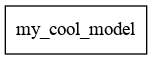

In [122]:
# 2. compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(loss="mse", loss_weights=[0.9, 0.1], optimizer=optimizer,
              metrics=["RootMeanSquaredError"])

# build the model
model.norm_layer_wide.adapt(X_train_wide)
model.norm_layer_deep.adapt(X_train_deep)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)))
tf.keras.utils.plot_model(model, show_shapes=True)

In [123]:
!rm ./model.png

In [124]:
# 3. evaluate the model and make predictions
eval_results = model.evaluate((X_test_wide, X_test_deep), (y_test, y_test))
weighted_sum_of_losses, main_loss, aux_loss, main_rmse, aux_rmse = eval_results
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

 46/162 [=======>......................] - ETA: 0s - loss: 0.3735 - output_1_loss: 0.3658 - output_2_loss: 0.4435 - output_1_root_mean_squared_error: 0.6048 - output_2_root_mean_squared_error: 0.6660

162/162 [==============================] - 0s 1ms/step - loss: 0.3579 - output_1_loss: 0.3494 - output_2_loss: 0.4345 - output_1_root_mean_squared_error: 0.5911 - output_2_root_mean_squared_error: 0.6592


Save and load models
---
- A trained Keras model can be saved by calling its `save()` method
- the popular model file formats include
  - TensorFlow’s SavedModel format `save_format="tf"` which is a directory containing several files and subdirectories
    - the `saved_model.pb` file contains the model’s architecture and logic in the form of a `serialized computation graph`
    - it contains sufficient information for deployment
    - the `keras_metadata.pb` file contains extra information needed by Keras
    - the `variables subdirectory` contains all the parameter values including 
      - the connection weights, the biases, the normalization statistics, and the optimizer’s parameters
      - possibly split across multiple files if the model is very large
    - the `assets directory` may contain extra files, such as data samples, feature names, class names, and so on. It is empty by default.
- `save_format="h5"` or using a filename with extensions of .h5, .hdf5, or .keras
  - Keras will save the model to a single file using a Keras-specific format based on the HDF5 format
- `tf.keras.models.load_model` loads a model
- `save_weights()` and `load_weights()` save and load only the parameter values
  - perfect for saving quick checkpoints during training large models


In [125]:
# 1. save a model
import shutil # remove unneeded models
shutil.rmtree("my_keras_model", ignore_errors=True)

model.save("my_keras_model", save_format="tf")
!tree ./my_keras_model

INFO:tensorflow:Assets written to: my_keras_model/assets
./my_keras_model
├── assets
├── keras_metadata.pb
├── saved_model.pb
└── variables
    ├── variables.data-00000-of-00001
    └── variables.index

2 directories, 4 files


In [126]:
# 2. load a model
model = tf.keras.models.load_model("my_keras_model")
y_pred_main, y_pred_aux = model.predict((X_new_wide, X_new_deep))

In [127]:
# 3. save and load weights
model.save_weights("my_weights")
model.load_weights("my_weights")

!ls my_weights*

my_weights.data-00000-of-00001	my_weights.index


In [128]:
# clean the generated folders and files
!rm -rf my_keras_model
!rm -f my_weights* checkpoint

Save checkpoints with callbacks
---
- the `fit()` argument `callbacks`  accepts a list of objects for further processing 
  - before and after training, each epoch, and each batch
  - or at regular intervals during training
- there are also callbacks accepted by `evaluate()` and `predict()`

In [129]:
# 1. use callback `ModelCheckpoint` to save checkpoints of your model 
# at regular intervals during training, 
# by default at the end of each epoch

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints",
                                                   save_weights_only=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb])

Epoch 1/10


363/363 [==============================] - 1s 2ms/step - loss: 0.3729 - output_1_loss: 0.3655 - output_2_loss: 0.4389 - output_1_root_mean_squared_error: 0.6046 - output_2_root_mean_squared_error: 0.6625 - val_loss: 0.7680 - val_output_1_loss: 0.7994 - val_output_2_loss: 0.4850 - val_output_1_root_mean_squared_error: 0.8941 - val_output_2_root_mean_squared_error: 0.6964
Epoch 2/10
363/363 [==============================] - 1s 1ms/step - loss: 0.3594 - output_1_loss: 0.3521 - output_2_loss: 0.4254 - output_1_root_mean_squared_error: 0.5934 - output_2_root_mean_squared_error: 0.6523 - val_loss: 0.6260 - val_output_1_loss: 0.6329 - val_output_2_loss: 0.5632 - val_output_1_root_mean_squared_error: 0.7956 - val_output_2_root_mean_squared_error: 0.7505
Epoch 3/10
363/363 [==============================] - 0s 1ms/step - loss: 0.3635 - output_1_loss: 0.3572 - output_2_loss: 0.4201 - output_1_root_mean_squared_error: 0.5977 - output_2_root_mean_squared_error: 0.6482 - val_loss: 0.4588 - val_out

In [130]:
# 2. to stop training at the moment with best performance using callback `EarlyStopping`
#  It will interrupt training when it measures no progress on the validation set 
#   for a number of epochs (defined by the `patience` argument),
# The EarlyStopping callback will store the weights of the best model in RAM, 
# and it will restore them for you at the end of training.

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=100,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
 42/363 [==>...........................] - ETA: 0s - loss: 0.3275 - output_1_loss: 0.3239 - output_2_loss: 0.3602 - output_1_root_mean_squared_error: 0.5691 - output_2_root_mean_squared_error: 0.6002

363/363 [==============================] - 1s 1ms/step - loss: 0.3370 - output_1_loss: 0.3308 - output_2_loss: 0.3928 - output_1_root_mean_squared_error: 0.5752 - output_2_root_mean_squared_error: 0.6267 - val_loss: 0.5780 - val_output_1_loss: 0.6006 - val_output_2_loss: 0.3748 - val_output_1_root_mean_squared_error: 0.7750 - val_output_2_root_mean_squared_error: 0.6122
Epoch 2/100
363/363 [==============================] - 0s 1ms/step - loss: 0.3408 - output_1_loss: 0.3351 - output_2_loss: 0.3917 - output_1_root_mean_squared_error: 0.5789 - output_2_root_mean_squared_error: 0.6259 - val_loss: 1.0341 - val_output_1_loss: 1.0437 - val_output_2_loss: 0.9477 - val_output_1_root_mean_squared_error: 1.0216 - val_output_2_root_mean_squared_error: 0.9735
Epoch 3/100
363/363 [==============================] - 1s 1ms/step - loss: 0.3449 - output_1_loss: 0.3396 - output_2_loss: 0.3933 - output_1_root_mean_squared_error: 0.5827 - output_2_root_mean_squared_error: 0.6271 - val_loss: 0.4975 - val_o

In [131]:
# 3. show the comparison between validation loss and training loss 
# by subclassing class `Callback` and override the callbacks you want
# 1) training callbacks called by `fit()`: 
#   on_train_begin(), on_train_end(), on_epoch_begin(), on_epoch_end(), 
#   on_batch_begin(), and on_batch_end()
# 2) evaluation callbacks called by `evaluate()`:
#   on_test_begin(), on_test_end(), on_test_batch_begin(), or on_test_batch_end()
# 3) prediction callbacks called by `predict()`
#   on_predict_begin(), on_predict_end(), on_predict_batch_begin(), or on_predict_batch_end()
# for further info, refer to `tf.keras.callbacks package`

class PrintValTrainRatioCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        ratio = logs["val_loss"] / logs["loss"]
        print(f"Epoch={epoch}, val/train={ratio:.2f}")
        
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(
    (X_train_wide, X_train_deep), (y_train, y_train), epochs=10,
    validation_data=((X_valid_wide, X_valid_deep), (y_valid, y_valid)),
    callbacks=[val_train_ratio_cb], verbose=0)        

Epoch=0, val/train=1.06
Epoch=1, val/train=1.03
Epoch=2, val/train=0.99
Epoch=3, val/train=1.07
Epoch=4, val/train=1.24
Epoch=5, val/train=2.33
Epoch=6, val/train=1.10
Epoch=7, val/train=0.98
Epoch=8, val/train=1.11
Epoch=9, val/train=1.00


Visualization with TensorBoard
---
With TensorBoard, you can interactively 
-  view the learning curves during training
-  compare curves and metrics between multiple runs
-  visualize the computation graph
-  analyze training statistics
-  view images generated by your model
-  visualize complex multidimensional data projected down to 3D and automatically clustered for you
-  profile your network (i.e., measure its speed to identify bottlenecks), etc.


How TensorBoard works?
---
- ML programs output binary logfiles called `event files`
  - Each binary data record is called a `summary`
- The TensorBoard server monitors the log directory
  - automatically picks up the changes and updates the visualization

In [132]:
# 1. TensorBoard is installed automatically with TensorFlow
#  but to visualize profiling data, ` tensorboard-plugin-profile` is needed
if "google.colab" in sys.modules:
  %pip install -q -U tensorboard-plugin-profile

In [133]:
# 2.  you want to point the TensorBoard server to a root log directory 
# and configure your program so that 
# it writes to a different subdirectory every time it runs

shutil.rmtree("my_logs", ignore_errors=True)
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir="my_logs"):
    return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S")

run_logdir = get_run_logdir()

In [134]:
# 3. Keras `TensorBoard()` callback can 
# - create the log directory, event files and write summaries during training
# - measure your model’s training and validation loss and metrics
# - profile your neural network

# 1) build a regression nn for visualization demo
tf.keras.backend.clear_session()

norm_layer = tf.keras.layers.Normalization(input_shape=X_train.shape[1:])
model = tf.keras.Sequential([
    norm_layer,
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(1)
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])
norm_layer.adapt(X_train)

# 2) setup Keras `TensorBoard()` callback
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir,
                                                profile_batch=(100, 200))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[tensorboard_cb])

2024-03-11 14:13:29.755796: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2024-03-11 14:13:29.755831: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2024-03-11 14:13:29.756517: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


Epoch 1/20
200/363 [===============>..............] - ETA: 0s - loss: 2.6568 - root_mean_squared_error: 1.6300

2024-03-11 14:13:30.038549: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2024-03-11 14:13:30.038583: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2024-03-11 14:13:30.132156: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2024-03-11 14:13:30.144326: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2024-03-11 14:13:30.169358: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_2024_03_11_14_13_29/plugins/profile/2024_03_11_14_13_30

2024-03-11 14:13:30.187172: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to my_logs/run_2024_03_11_14_13_29/plugins/profile/2024_03_11_14_13_30/wolongtan.trace.json.gz
2024-03-11 14:13:30.198656: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: my_logs/run_2024_03_11_14_13_29/plugin

363/363 [==============================] - 1s 1ms/step - loss: 1.8866 - root_mean_squared_error: 1.3736 - val_loss: 0.7126 - val_root_mean_squared_error: 0.8442
Epoch 2/20
363/363 [==============================] - 0s 974us/step - loss: 0.6577 - root_mean_squared_error: 0.8110 - val_loss: 0.6880 - val_root_mean_squared_error: 0.8295
Epoch 3/20
363/363 [==============================] - 0s 965us/step - loss: 0.5934 - root_mean_squared_error: 0.7703 - val_loss: 0.5803 - val_root_mean_squared_error: 0.7618
Epoch 4/20
363/363 [==============================] - 0s 953us/step - loss: 0.5557 - root_mean_squared_error: 0.7455 - val_loss: 0.5166 - val_root_mean_squared_error: 0.7188
Epoch 5/20
363/363 [==============================] - 0s 954us/step - loss: 0.5272 - root_mean_squared_error: 0.7261 - val_loss: 0.4895 - val_root_mean_squared_error: 0.6997
Epoch 6/20
363/363 [==============================] - 0s 968us/step - loss: 0.5033 - root_mean_squared_error: 0.7094 - val_loss: 0.4951 - val_r

In [135]:
# 3) check the generated logfiles
!tree my_logs/

my_logs/
└── run_2024_03_11_14_13_29
    ├── events.out.tfevents.1710180810.wolongtan.profile-empty
    ├── plugins
    │   └── profile
    │       └── 2024_03_11_14_13_30
    │           ├── wolongtan.input_pipeline.pb
    │           ├── wolongtan.kernel_stats.pb
    │           ├── wolongtan.memory_profile.json.gz
    │           ├── wolongtan.overview_page.pb
    │           ├── wolongtan.tensorflow_stats.pb
    │           ├── wolongtan.trace.json.gz
    │           └── wolongtan.xplane.pb
    ├── train
    │   └── events.out.tfevents.1710180809.wolongtan.3449.0.v2
    └── validation
        └── events.out.tfevents.1710180810.wolongtan.3449.1.v2

6 directories, 10 files


In [136]:
# 4) load the `tensorboard` Jupyter extension 
%load_ext tensorboard

#  starts a TensorBoard server for the my_logs directory
%tensorboard --logdir=./my_logs


In [137]:
# 5) access TensorBoard in a separate tab, click the "localhost:6006" link below:
import sys
if "google.colab" in sys.modules:
    from google.colab import output

    output.serve_kernel_port_as_window(6006)
else:
    from IPython.display import display, HTML

    display(HTML('<a href="http://localhost:6006/">http://localhost:6006/</a>'))

In [138]:
# 6) Log histograms, images, text, and audio using
# TensorFlow lower-level API in the tf.summary package
# which can be visualized in TensorBoard 
# click the refresh button in TensorBoard to see what happened?

test_logdir = get_run_logdir()
writer = tf.summary.create_file_writer(str(test_logdir))
with writer.as_default():
    for step in range(1, 1000 + 1):
        tf.summary.scalar("my_scalar", np.sin(step / 10), step=step)
        
        data = (np.random.randn(100) + 2) * step / 100  # gets larger
        tf.summary.histogram("my_hist", data, buckets=50, step=step)
        
        images = np.random.rand(2, 32, 32, 3) * step / 1000  # gets brighter
        tf.summary.image("my_images", images, step=step)
        
        texts = ["The step is " + str(step), "Its square is " + str(step ** 2)]
        tf.summary.text("my_text", texts, step=step)
        
        sine_wave = tf.math.sin(tf.range(12000) / 48000 * 2 * np.pi * step)
        audio = tf.reshape(tf.cast(sine_wave, tf.float32), [1, -1, 1])
        tf.summary.audio("my_audio", audio, sample_rate=48000, step=step)

In [139]:
# 7) find and kill the TensorBoard server process if no longer used
from tensorboard import notebook

notebook.list()

Known TensorBoard instances:
  - port 6006: logdir ./my_logs (started 0:00:07 ago; pid 12670)


In [ ]:
# !kill 120670

Fine-Tune Neural Network Hyperparameters such as
---
- the number of layers
- the number of neurons and the type of activation function to use in each layer
- the weight initialization logic
- the type of optimizer to use
- its learning rate, the batch size, etc.

two ways:
- convert your Keras model to a Scikit-Learn estimator
  - use the `KerasRegressor` and `KerasClassifier` wrapper classes from [the `SciKeras` library](https://github.com/adriangb/scikeras)
  - then use GridSearchCV or RandomizedSearchCV to finetune the hyperparameters
- use the Keras Tuner library on your Keras models directly

In [141]:
# 1. install `keras-tuner`
if "google.colab" in sys.modules:
    %pip install -q -U keras-tuner

In [142]:
import keras_tuner as kt

In [143]:
# 2. use the Fashion MNIST dataset again
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

tf.keras.backend.clear_session()

In [144]:
# 3. determine the hyperparameters and their ranges to try
#   4 sets of hyperparameters:
# - number of hidden layers (n_hidden), 
# - the number of neurons perlayer (n_neurons), 
# - the learning rate (learning_rate), 
# - the type of optimizer to use (optimizer)

def build_model(hp:  kt.HyperParameters):
    # register hyperparameters and their ranges
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2,
                             sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # build the model with the hyperparameters
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [145]:
# 4) search for the best hyperparameters randomly for 5 trials
#   for each trial it builds a model using hyperparameters sampled 
#   randomly within their respective ranges, 
#   then it trains that model for 10 epochs and saves it to a subdirectory of the
#   `my_fashion_mnist/my_rnd_search` directory

# - overwrite=True, the my_rnd_search directory is deleted before training starts
# - overwrite=False,  the tuner will continue tuning where it left off, running 5 more trials
# - objective="val_accuracy", the tuner prefers models with a higher validation accuracy

random_search_tuner = kt.RandomSearch(
    build_model, objective="val_accuracy", max_trials=5, overwrite=True,
    directory="my_fashion_mnist", project_name="my_rnd_search", seed=42)

random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 5 Complete [00h 00m 25s]
val_accuracy: 0.8342000246047974

Best val_accuracy So Far: 0.8618000149726868
Total elapsed time: 00h 02m 05s


In [146]:
# get the best model
top3_models = random_search_tuner.get_best_models(num_models=3)
best_model = top3_models[0]

In [147]:
# get the best parameter values of the best model
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=3)
top3_params[0].values

{'n_hidden': 7,
 'n_neurons': 100,
 'learning_rate': 0.0012482904754698163,
 'optimizer': 'sgd'}

In [148]:
# get the best trial
#   Each tuner is guided by a so-called oracle: 
#   before each trial, the oracle tell the turner what's next trial 
#   The RandomSearch tuner uses a RandomSearchOracle
#     which just picks the next trial randomly

best_trial = random_search_tuner.oracle.get_best_trials(num_trials=3)[0]
best_trial.summary()

Trial 1 summary
Hyperparameters:
n_hidden: 7
n_neurons: 100
learning_rate: 0.0012482904754698163
optimizer: sgd
Score: 0.8618000149726868


In [149]:
# train the best model fully
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3261 - accuracy: 0.8790
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3166 - accuracy: 0.8822
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3087 - accuracy: 0.8850
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3000 - accuracy: 0.8889
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2937 - accuracy: 0.8906
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2852 - accuracy: 0.8938
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2803 - accuracy: 0.8947
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2750 - accuracy: 0.8964
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2679 - accuracy: 0.8992
Epoch 10/10
313/313 [==============================] - 0s 1ms/step - loss: 0.3965 

NN further fine-tuning
---
- to fine-tune  data preprocessing hyperparameters, or model.fit() arguments, such as the batch size, you must subclass the `kt.HyperModel class` and override two methods
  - `build()` does the exact same thing as the `build_model()` function
  - `fit()` takes as arguments a `HyperParameters` object, a compiled model, all the `model.fit()` arguments 
    - to decide how to preprocess the data, tweak the batch size, etc.
    - then fits the model and returns the History object

In [150]:
# 1. build the same model as before, with the same hyperparameters, 
# but it also uses a Boolean "normalize" hyperparameter to control 
# whether or not to standardize the training data before fitting the model

class MyClassificationHyperModel(kt.HyperModel):
    def build(self, hp):
        return build_model(hp)

    def fit(self, hp, model, X, y, **kwargs):
        if hp.Boolean("normalize"):
            norm_layer = tf.keras.layers.Normalization()
            X = norm_layer(X)
        return model.fit(X, y, **kwargs)

In [151]:
# 2.  build a kt.Hyperband tuner based on a `MyClassificationHyperModel` instance
# This tuner is similar to the HalvingRandomSearchCV class,
#   - starts by training many different models for few epochs
#   - eliminates the worst models and keeps only the `top 1 / factor` models
#       the top third in this case
#   - repeats this selection process until a single model is left
#   - by argument `max_epochs` controls the max number of epochs that 
#       the best model will be trained for
#   - by `hyperband_iterations=2` repeats whole process twice
# The total number of training epochs across all models for each hyperband iteration is 
# about `max_epochs * (log(max_epochs) / log(factor)) ** 2`, so it’s about 44 epochs. 
# The other arguments are the same as for `kt.RandomSearch`

hyperband_tuner = kt.Hyperband(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_epochs=10, factor=3, hyperband_iterations=2,
    overwrite=True, directory="my_fashion_mnist", project_name="hyperband")

In [152]:
# 3.  run a Hyperband tuner
# use the TensorBoard callback pointing to the root log directory 
# (the tuner will take care of using a different subdirectory for each trial), 
# and an EarlyStopping callback
from pathlib import Path
root_logdir = Path(hyperband_tuner.project_dir) / "tensorboard"
tensorboard_cb = tf.keras.callbacks.TensorBoard(root_logdir)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
hyperband_tuner.search(X_train, y_train, epochs=10,
                       validation_data=(X_valid, y_valid),
                       callbacks=[early_stopping_cb, tensorboard_cb])

Trial 60 Complete [00h 00m 26s]
val_accuracy: 0.8519999980926514

Best val_accuracy So Far: 0.8812000155448914
Total elapsed time: 00h 10m 45s


kt.BayesianOptimization tuner
---
- Hyperband is smarter than pure random search in the way it allocates resources
  - but at its core it still explores the hyperparameter space randomly
  - it’s fast, but coarse
- kt.BayesianOptimization tuner gradually learns 
  - which regions of the hyperparameter space are most promising 
  - by fitting a probabilistic model called a Gaussian process
  - This allows it to gradually zoom in on the best hyperparameters
- Hyperparameter tuning is still an active area of research
  - AutoML uses `evolutionary algorithm` to jointly optimize 
    - a population of models and their hyperparameters
  - Evolutionary algorithms are also used to train individual neural networks, 
    - replacing the ubiquitous gradient descent

In [153]:
# 4. run a BayesianOptimization tuner
# - `alpha` represents the level of noise you expect 
#   - in the performance measures across trials 
#   - it defaults to 10⁻⁴
# - `beta` specifies how much you want the algorithm to explore, 
#   - instead of simply exploiting the known good regions of hyperparameter space
#   - it defaults to 2.6
bayesian_opt_tuner = kt.BayesianOptimization(
    MyClassificationHyperModel(), objective="val_accuracy", seed=42,
    max_trials=10, alpha=1e-4, beta=2.6,
    overwrite=True, directory="my_fashion_mnist", project_name="bayesian_opt")
bayesian_opt_tuner.search(X_train, y_train, epochs=10,
                          validation_data=(X_valid, y_valid),
                          callbacks=[early_stopping_cb])

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.8411999940872192

Best val_accuracy So Far: 0.8575999736785889
Total elapsed time: 00h 03m 33s


In [154]:
# 5. visualize with TensorBoard
%load_ext tensorboard
%tensorboard --port 6007 --logdir {root_logdir}

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [155]:
# cleanup generated data
!rm -rf ./my_fashion_mnist ./my_logs
!rm -f *checkpoint*

Guidelines on hyperparameter tuning
---
- Number of hidden layers
  - begin with a MLP with a single hidden layer 
    - ∵ theoretically it can model most complex functions with enough neurons
    - it can get reasonable results for many problems
  - But for complex problems, deep networks have a much higher parameter efficiency than shallow ones
    - DNNs use exponentially fewer neurons than shallow nets, and
      - reach much better performance with the same amount of training data
      - converge faster to a good solution
      - generalize better to new datasets
    - ∵ Real-world data is often structured in such a hierarchical way as DNNs
      - lower hidden layers model low-level simple structures (e.g. cells)
      - intermediate hidden layers combine these low-level structures to model intermediate-level structures (e.g. organs)
      - the highest hidden layers and the output layer combine these intermediate structures to model high-level structures (e.g. living beings)
    - lower layers and intermediate layers can be reused for other DNNs
      - this is called `transfer learning`
      - i.e. their structures, parameters and biases are all reused
      - only the new high layers and output layers need new training
      - mainly used in large scale NNs with dozens even hundreds of layers for complex tasks
        - e.g. large image classification, speech recognition, etc.
  - `practice`: increase the number of layers gradually until the network starts overfitting
- Number of neurons per hidden layer
  - the numbers of neurons in the input and output layers are determined by 
    - the type and number of input and output specific to the task
      - e.g. MNIST task requires 28 × 28 = 784 inputs and 10 output neurons
    - the same number of neurons in all hidden layers is preferred
      - a layer with too few neurons will not have enough representational power 
        - to preserve all the useful information from the inputs
    - the old practice with a plausible rationale is abandoned:
      - many low-level features can coalesce into far fewer high-level features 
      - using fewer and fewer neurons at each hidden layer from input layer to output layer
  - `practice`: increase the number of neurons gradually until the network starts overfitting
- Learning rate, batch size, and other hyperparameters
  - Batch size
    - large batch sizes are suitable for hardware accelerators like GPUs
      - but often lead to training instabilities, especially at the beginning of training
    - it was possible to use very large batch sizes (up to 8,192) along with various techniques such as warming up the learning rate
    - `practice`: try to using a large batch size, with learning rate warmup, and if training is unstable or the final performance is disappointing, then try using a small batch size instead
  - Learning rate
    - generally the optimal learning rate is about half of the maximum learning rate (mlr)
      - the mlr is the learning rate above which the training algorithm diverges
    - the optimal learning rate is a bit lower than the point at which the loss starts to climb on the curve of loss vs. learning rate
      - typically about 10 times lower than the turning point  
  - Activation function
    - generally the `ReLU` activation function will be a good default for all hidden layers
    - but for the output layer it depends on your task
  - Optimizer
    - Choose a better optimizer than plain old mini-batch gradient descent
  - Number of iterations
    - no need to be tweaked: just use early stopping instead

# References
- [sklearn Neural network models (supervised)](https://scikit-learn.org/stable/modules/neural_networks_supervised.html)
- [sklearn Neural network models (unsupervised)](https://scikit-learn.org/stable/modules/neural_networks_unsupervised.html)
- [Keras](https://keras.io/)